In [2]:
%matplotlib inline
# You need to have caffe installed with python support, and the BVLC reference models
# downloadad.  Please refer to the caffe website/codebase for instructions.
import caffe
import progressbar
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as pmg
caffe.set_mode_gpu()
caffe.set_mode_gpu()
DIR = 'originMnist/'
MNmodel = DIR + 'model.net'
MNweight = DIR + 'para_iter_5000.caffemodel'
# NOTE: you must change deploy.prototxt to include "force_backward: true"
net = caffe.Net(MNmodel, MNweight, 1)

In [96]:
net.blobs

OrderedDict([('data', <caffe._caffe.Blob at 0x7f2ed55fdde8>),
             ('conv1', <caffe._caffe.Blob at 0x7f2ed4ef4ed8>),
             ('pool1', <caffe._caffe.Blob at 0x7f2ed56dcf50>),
             ('conv2', <caffe._caffe.Blob at 0x7f2ed5a14a28>),
             ('pool2', <caffe._caffe.Blob at 0x7f2ed53089b0>),
             ('ip1', <caffe._caffe.Blob at 0x7f2ed5308a28>),
             ('ip2', <caffe._caffe.Blob at 0x7f2ed53088c0>),
             ('loss', <caffe._caffe.Blob at 0x7f2ed50b2410>)])

In [138]:
def transformCurrent(current, means):
    image = (current + means).transpose(1,2,0)[:,:,0]
    image = image - image.min()
    image = image/image.max()
    return image
def oneLoop(net, diffpic, endL='pool2', initpic=None, IT=1000, rate_obj=1000, means=0.4, a=1, b=0.5):
    
    diffpic = pmg.imread(diffpic)[None,:,:]
    diffpic = (diffpic - means)*255
    net.blobs['data'].data[...] = diffpic
    DIFF = net.forward(end=endL)[endL]
    print DIFF.shape
    
    if initpic == None:
        current = np.random.rand(1,28,28)
    else:
        current = pmg.imread(initpic)[None,:,:]
        print 'with init'
    current = (current - means)*255
    
    
    prg = progressbar.ProgressBar(max_value=IT).start()
    plt.rcParams['figure.figsize'] = (20,20)
    
    fg = plt.figure()
    for it in range(IT):
        net.blobs['data'].data[...] = current
        net.forward(end=endL)
        net.blobs[endL].diff[...].flat = DIFF*0.01
        diff = net.backward(start=endL)['data']
        # gradient descent step
        current = current + rate_obj*diff[0]
        
        if it > 0 and it%100 == 0:
            #print 'iteration {}'.format(it)
            prg.update(it)
            sb = fg.add_subplot(10,10,it/100)
            sb.imshow(transformCurrent(current, means), cmap='gray')
            sb.set_title('it='+str(it))
    plt.show()
    return transformCurrent(current, means)

(1, 50, 4, 4)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:32: RuntimeWarning: overflow encountered in multiply


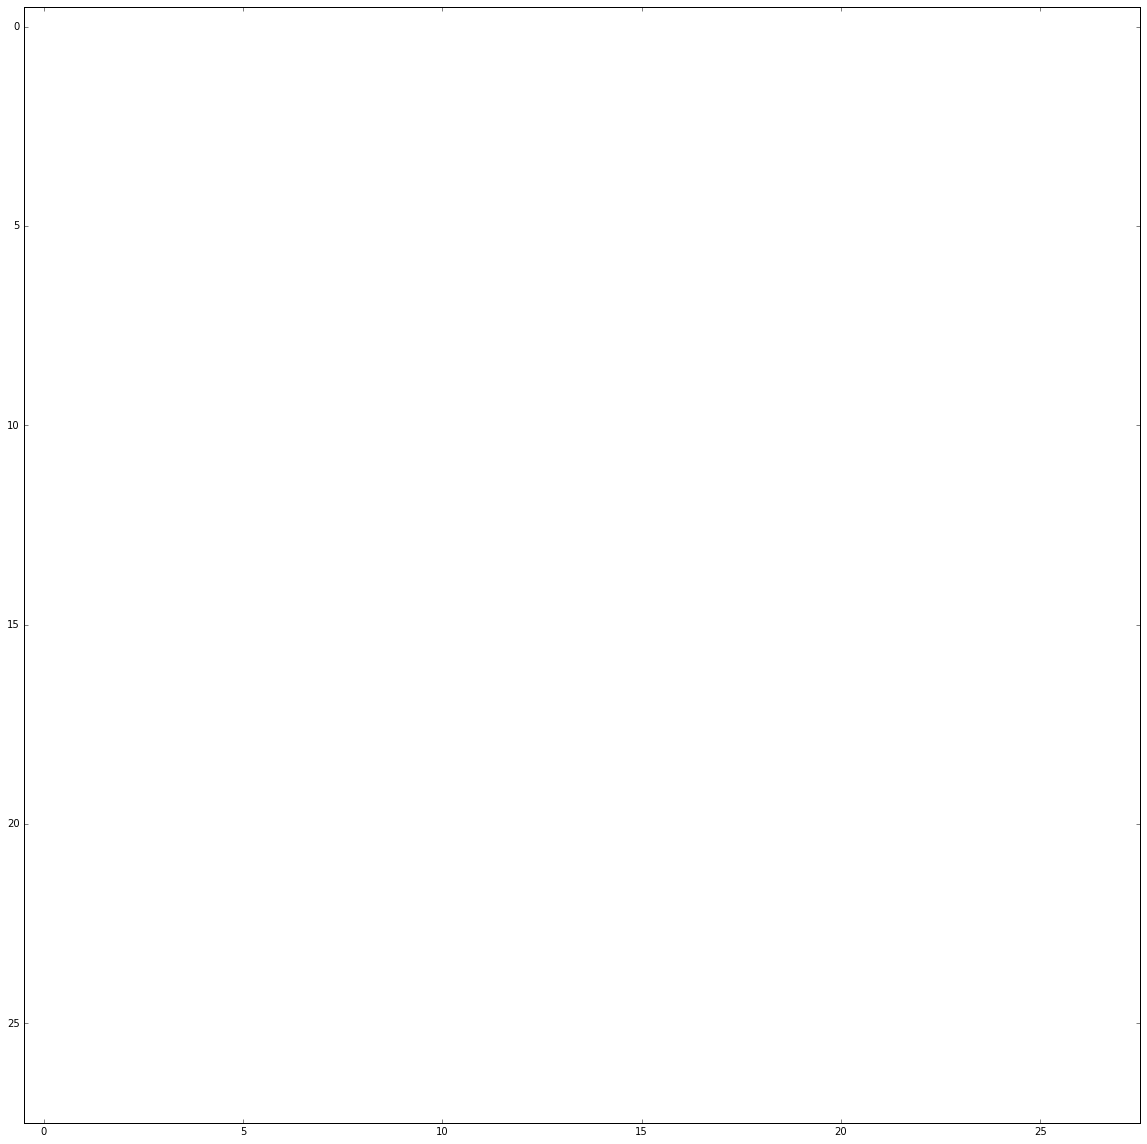

In [140]:
diffpic = '../data/single/6.png'
plt.rcParams['figure.figsize'] = (5,5)
plt.imshow(oneLoop(net, diffpic=diffpic, IT=50), cmap='gray')